In [14]:
import sys
sys.path.append("../") # go to parent dir

In [15]:
import pandas as pd
import seaborn as sn
import re
import os

from mimic3models.metrics import print_metrics_regression

In [16]:
path = "/mnt/data01/models/cnn/predictions/"
filename = "both_test_result.csv"
df_cnn = pd.read_csv(os.path.join(path, filename))
df_index = pd.read_csv("/mnt/data01/models/cnn/predictions/test_5_5000_idx.csv")

print(df_cnn.describe(include="all"))
print(df_index.describe(include="all"))


               Hours           True      Predicted
count  342890.000000  342890.000000  342890.000000
mean      141.049883     125.143485     107.776282
std       198.823087     140.659914      79.809145
min         5.000000       2.516800     -12.620460
25%        26.362499      27.417000      42.980639
50%        65.566666      68.210000      85.348030
75%       171.256741     170.547800     159.698494
max      1963.721924     670.462400   10540.767578
                  idx     patient_id   episode     window_idx
count   342890.000000  342890.000000    342890  342890.000000
unique            NaN            NaN        18            NaN
top               NaN            NaN  episode1            NaN
freq              NaN            NaN    275496            NaN
mean    171444.500000   35889.601132       NaN     109.564893
std      98983.961239   28574.690391       NaN     130.087442
min          0.000000       4.000000       NaN       0.000000
25%      85722.250000   13705.000000       Na

In [17]:
df_cnn_combine = pd.concat([df_cnn, df_index], axis=1)
df_cnn_combine["EPISODE_ID"] = df_cnn_combine["episode"].apply(lambda x: int(re.findall(r'episode[0-9]', x)[-1][7:]))
df_cnn_combine.rename(columns={"patient_id": "PATIENT_ID", "Hours": "period_length", "Predicted": "prediction", "True" : "y_true"}, inplace=True)
df_cnn_combine["stay"] = df_cnn_combine.apply(lambda x: f"{x.PATIENT_ID}_episode{x.EPISODE_ID}_timeseries.csv", axis=1)
df_cnn_combine.head(2)


,period_length,y_true,prediction,idx,PATIENT_ID,episode,window_idx,EPISODE_ID,stay
0,5.428056,8.3216,95.740395,0,15511,episode1,0,1,15511_episode1_timeseries.csv
1,6.428056,7.3216,196.716431,1,15511,episode1,1,1,15511_episode1_timeseries.csv


In [18]:
# Write out new file
df_cnn_combine[["stay", "period_length", "prediction", "y_true"]].to_csv(os.path.join(path, f"stay_{filename}"))

In [3]:
period_bins = [5, 12, 24, 36, 48, 60, 72]

# [4 weeks, 2 weeks, 1 week, 3 days, 2.5 days, 2 days, 1.5 days, 1 day, .5 days]
# remain_bins = [672, 336, 168, 72, 60, 48, 36, 24, 12]
remain_bins = [336, 240, 168, 120, 72, 60, 48, 36, 24, 12]

In [4]:
model_metrics = {}
models = {
    "lstm (note-reg)" : "/mnt/data01/models/lstm_notes_bert/regression/test_predictions/k_lstm.n64.d0.3.dep1.bs8.ts1.0.partition=none.chunk01.test1.4984.state.csv",
    "lstm (reg)" : "/mnt/data01/models/lstm/regression/test_predictions/k_lstm.n64.d0.3.dep1.bs256.ts1.0.partition=none.chunk08.test1.2235.state.csv",
    "lstm (bin)" : "/mnt/data01/models/lstm/custom/test_predictions/k_lstm.n64.d0.3.dep1.bs256.ts1.0.partition=custom.chunk14.test1.7325.state.csv",
    "lin reg" : "/mnt/data01/models/linear_regression/regression/predictions/all.all.csv",
    "log reg" : "/mnt/data01/models/linear_regression/logistic/cf_predictions/all.all.l2.C1e-05.csv"
}
model_keys = list(models.keys())
model_keys

['lstm (note-reg)', 'lstm (reg)', 'lstm (bin)', 'lin reg', 'log reg']

In [35]:
model = model_keys[len(model_metrics)]
model_metrics[model] = {}
df = pd.read_csv(models[model])
print(model)
df.describe(include="all")

lstm (reg)


,stay,period_length,prediction,y_true
count,525912,525912.000000,525912.000000,525912.000000
unique,6265,NaN,NaN,NaN
top,12805_episode1_timeseries.csv,NaN,NaN,NaN
freq,1988,NaN,NaN,NaN
mean,NaN,143.687375,79.475577,139.145741
std,NaN,202.474764,62.609560,202.464813
min,NaN,5.000000,0.000000,0.000000
25%,NaN,27.000000,24.447373,22.282400
50%,NaN,65.000000,53.176490,60.782000
75%,NaN,173.000000,138.008449,168.562400


In [36]:
# Add patient to the table
df["PATIENT_ID"] = df["stay"].apply(lambda x: int(re.findall(r'[0-9]+_', x)[0][:-1]))
df["EPISODE_ID"] = df["stay"].apply(lambda x: int(re.findall(r'episode[0-9]+_', x)[-1][7:-1]))


In [37]:
stay_df = df.groupby(df.stay, as_index=False)["period_length"].agg("max")
print(stay_df.describe())

       period_length
count    6265.000000
mean       87.970790
std       127.748688
min         5.000000
25%        28.000000
50%        49.000000
75%        91.000000
max      1992.000000


[Text(0.5, 0, 'LOS (Hours)')]

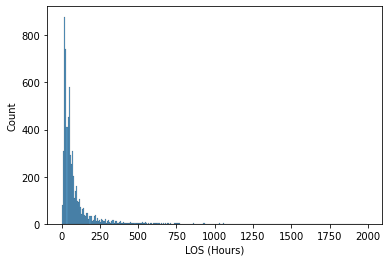

In [38]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

[Text(0.5, 0, 'LOS (Hours)')]

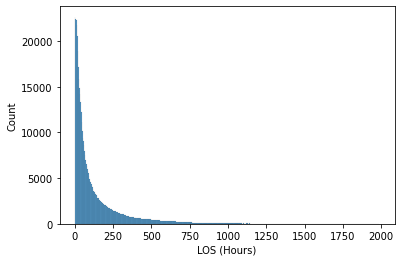

In [39]:
fig = sn.histplot(data=df, x="y_true") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

[Text(0.5, 0, 'LOS (Hours)')]

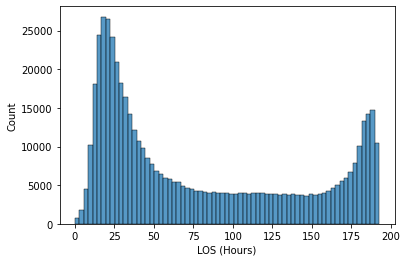

In [40]:
fig = sn.histplot(data=df, x="prediction") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

In [41]:
model_metrics[model]["all"] = print_metrics_regression(df["y_true"], df["prediction"], extra=True, custom_bin=0, fill_ones=True)

Custom bins confusion matrix:
[(-1e+18, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 14), (14, 1e+18)]
[[73748 42445  9614  4388  2692  2017  2036  2691    20     0]
 [27471 30849 11389  6105  4362  3462  2698  4109    33     0]
 [11567 16418  7463  4821  3864  3464  3361  5294    42     0]
 [ 5633  9612  5043  3318  3222  2671  3265  6007    25     0]
 [ 3062  5725  3269  2645  2564  2676  2684  5878    40     0]
 [ 1622  3709  2403  2060  2345  2391  2137  5522    38     0]
 [ 1060  2463  1773  1784  2036  1901  1942  5090    29     0]
 [  768  1794  1235  1400  1679  1579  1892  4784    15     0]
 [ 1572  5168  4550  5298  5767  6009  7601 19767   266     0]
 [ 1172  3799  3756  3910  5441  6409  7944 27642   637     1]]
Mean absolute deviation (MAD) = 94.93480128154525
Mean squared error (MSE) = 36253.06621090808
Mean absolute percentage error (MAPE) = 185.09350671825374
Cohen kappa score = 0.4132987891948974
F1(micro) = 0.24210053962374647
F1(macro) = 0.14158630

In [42]:
# Filter quantiles (Windsorization = 94%)
stay_df = stay_df[(stay_df.period_length > stay_df.period_length.quantile(.03)) & \
                  (stay_df.period_length < stay_df.period_length.quantile(.97))]
print(stay_df.describe())
df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")


       period_length
count    5839.000000
mean       72.739168
std        67.182868
min        17.000000
25%        29.000000
50%        49.000000
75%        86.000000
max       396.000000


[Text(0, 0.5, 'Count Episodes')]

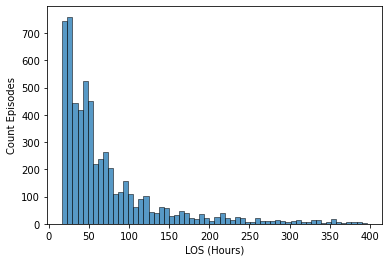

In [43]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')
fig.set(ylabel='Count Episodes')

In [44]:
model_metrics[model]["windsor"] = print_metrics_regression(df["y_true"], df["prediction"], extra=True, custom_bin=0, fill_ones=True)

Custom bins confusion matrix:
[(-1e+18, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 14), (14, 1e+18)]
[[72578 40604  8808  3780  2282  1673  1628  1767     0     0]
 [27256 30149 10863  5622  3891  3021  2275  2865     0     0]
 [11378 15789  7052  4345  3461  2976  2997  3760     0     0]
 [ 5470  9061  4631  2873  2763  2310  2931  4221     0     0]
 [ 2943  5275  2821  2152  2067  2230  2323  4195     1     0]
 [ 1564  3233  2030  1622  1762  1973  1752  3755     0     0]
 [ 1002  2158  1463  1275  1492  1474  1494  3184     0     0]
 [  720  1556   913   890  1222  1181  1421  2707     0     0]
 [ 1186  3663  2863  3214  3349  3418  4261  6827     1     0]
 [   20   164   211   330   279   286   181    50     0     1]]
Mean absolute deviation (MAD) = 42.97568996696361
Mean squared error (MSE) = 4110.233438666738
Mean absolute percentage error (MAPE) = 198.07108926275774
Cohen kappa score = 0.35621468058766803
F1(micro) = 0.3013079649281965
F1(macro) = 0.15180386

[Text(0.5, 0, 'LOS (Hours)')]

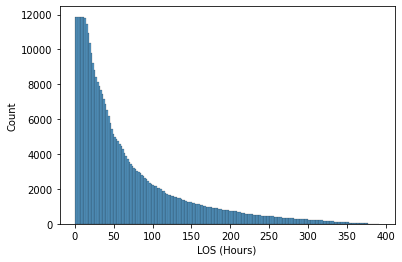

In [45]:
fig = sn.histplot(data=df, x="y_true") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

[Text(0.5, 0, 'LOS (Hours)')]

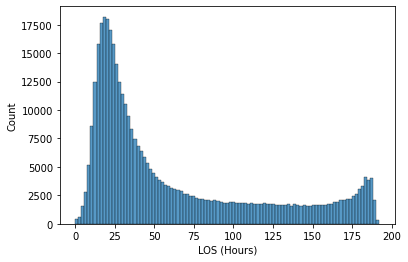

In [46]:
fig = sn.histplot(data=df, x="prediction") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

In [47]:
# Filter only those patiencts that have stay longer than ~ 1 std dev = 60
# stay_df = stay_df[stay_df.period_length >= 60]
# print(stay_df.describe())
# df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")


In [48]:
# fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
# fig.set(xlabel='LOS (Hours)')

In [49]:
# model_metrics[model][">60"] = print_metrics_regression(df["y_true"], df["prediction"], extra=True, custom_bin=0, fill_ones=True)

In [50]:
# Slice the data by period snapshots and test at each interval
df_list = []

period_df = df[df.period_length <= period_bins[0]].copy()
period_df["period_bin"] = period_bins[0]
df_list.append(period_df)

for bin in period_bins[1:]:
    period_df = df[df.period_length == bin].copy()
    period_df["period_bin"] = bin
    df_list.append(period_df)

period_df = pd.concat(df_list)
print(f"Period bins (hours): {period_bins}")
period_df.head(3)

Period bins (hours): [5, 12, 24, 36, 48, 60, 72]


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,period_bin
0,10000_episode1_timeseries.csv,5.0,32.016514,26.8312,10000,1,5
27,10011_episode1_timeseries.csv,5.0,57.529247,327.4168,10011,1,5
355,10012_episode1_timeseries.csv,5.0,50.408897,28.8952,10012,1,5


In [51]:
period_group_df = period_df.groupby("period_bin", as_index=False)["stay"].count()
period_group_df.head(10)

,period_bin,stay
0,5,5802
1,12,5832
2,24,5093
3,36,3888
4,48,3047
5,60,2334
6,72,1853


[Text(0.5, 0, 'With LOS greater than (Hours)'), Text(0, 0.5, 'Count')]

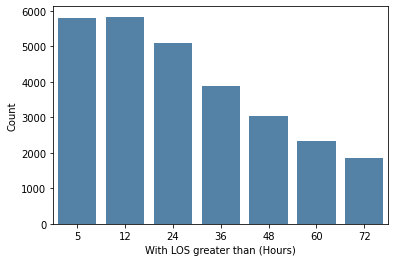

In [52]:
fig = sn.barplot(data=period_group_df, x="period_bin", y="stay", color="steelblue")
fig.set(xlabel='With LOS greater than (Hours)', ylabel='Count')


In [53]:
# # Bivariate histogram (heatmap)
# fig = sn.histplot(data=period_df, x="prediction", y="y_true") #, stat="probability")
# fig.set(xlabel='Predicted Remaining LOS (Hours)')
# fig.set(ylabel='Actual Remaining LOS (Hours)')
# fig.set(xlim=(-12,600))

In [54]:
period_metrics = []
for bin in period_bins:
    metric_df = period_df[period_df.period_bin == bin].copy()
    print(f"\nMetrics at {bin} hours")
    print(f'Unique episodes: {len(metric_df.stay.unique())}')
    print(f'Unique patients: {len(metric_df.PATIENT_ID.unique())}')
    metrics = print_metrics_regression(metric_df["y_true"], metric_df["prediction"], custom_bin=2, fill_ones=True)

    metrics["bin"] = bin
    metrics["model"] = model
    period_metrics.append(metrics)

if 'period_metrics_df' in locals():
    period_metrics_df = pd.concat([period_metrics_df, pd.DataFrame(period_metrics)])
else:
    period_metrics_df = pd.DataFrame(period_metrics)    


Metrics at 5 hours
Unique episodes: 5802
Unique patients: 4725
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[  1   0   0   0   0   0   0   0   0]
 [  0  13 385 488 252 165  93   0   0]
 [  0   3 170 294 183 108  80   0   0]
 [  0   5 169 294 219 152 121   0   0]
 [  0   0  59 148  95  83  66   0   0]
 [  0   2  79 127 107  83  97   0   0]
 [  1   3 111 269 276 249 274   0   0]
 [  0   1  18  59  73 123 153   1   0]
 [  0   0   1   5   6  16  30   0   1]]
Mean absolute deviation (MAD) = 40.13027160754912
Mean squared error (MSE) = 4258.691096361325
Mean absolute percentage error (MAPE) = 72.95564287846793
Cohen kappa score = 0.17263767597431912

Metrics at 12 hours
Unique episodes: 5832
Unique patients: 4742
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[ 12 324 249  71  28  20  43   0   0]
 [ 10 438 413 150  81  40  71   0  

[Text(0, 0.5, 'Mean Squared Error')]

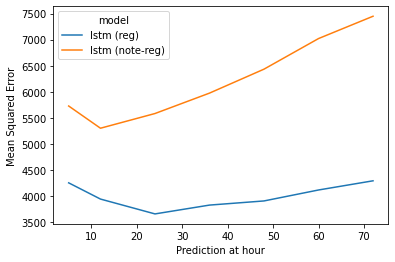

In [55]:
period_metrics_df = period_metrics_df.sort_values(by=["model","bin"], ascending=False)
fig = sn.lineplot(data=period_metrics_df, x="bin", y="mse", hue="model", sort=False)
fig.set(xlabel='Prediction at hour')
fig.set(ylabel='Mean Squared Error')

In [56]:
# Slice for Remaining bin statistics
df_list = []

for bin in remain_bins:
    remain_df = df[(df.y_true >= bin - 1) & (df.y_true < bin)].copy()
    remain_df["remain_bin"] = bin
    df_list.append(remain_df)

remain_df = pd.concat(df_list)
print(f"Remaining bins (hours): {remain_bins}")
remain_df.head(3)

Remaining bins (hours): [336, 240, 168, 120, 72, 60, 48, 36, 24, 12]


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,remain_bin
24770,12903_episode1_timeseries.csv,47.0,159.969879,335.6368,12903,1,336
27370,13345_episode1_timeseries.csv,49.0,175.809540,335.8088,13345,1,336
27836,1338_episode1_timeseries.csv,30.0,70.037560,335.7816,1338,1,336


In [57]:
remain_group_df = remain_df.groupby("remain_bin", as_index=False)["stay"].count()
remain_group_df.head(10)

,remain_bin,stay
0,12,5837
1,24,4529
2,36,3658
3,48,2696
4,60,2209
5,72,1704
6,120,835
7,168,493
8,240,237
9,336,60


[Text(0.5, 0, 'LOS Remaining (Hours)'), Text(0, 0.5, 'Count')]

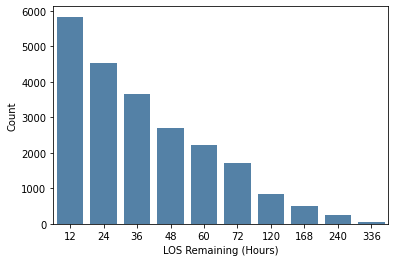

In [58]:
fig = sn.barplot(data=remain_group_df, x="remain_bin", y="stay", color="steelblue")
fig.set(xlabel='LOS Remaining (Hours)', ylabel='Count')

In [59]:
# # Bivariate histogram (heatmap)
# fig = sn.histplot(data=remain_df, x="prediction", y="y_true") #, stat="probability")
# fig.set(xlabel='Predicted Remaining LOS (Hours)')
# fig.set(ylabel='Actual Remaining LOS (Hours)')
# fig.set(xlim=(-12,400))

In [60]:
print(f'Unique episodes: {len(remain_df.stay.unique())}')
print(f'Unique patients: {len(remain_df.PATIENT_ID.unique())}')

model_metrics[model]["remain"] = print_metrics_regression(remain_df["y_true"], remain_df["prediction"], extra=True, custom_bin=2, fill_ones=True)

Unique episodes: 5837
Unique patients: 4745
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[ 453 2534 1449  504  264  134  419   81    0]
 [ 267 1553 1094  555  280  180  512   89    0]
 [ 108  978  865  467  260  194  674  113    0]
 [  85  607  546  335  221  160  594  149    0]
 [  32  440  401  278  179  138  586  156    0]
 [  34  291  294  182  123  111  505  165    0]
 [  13  116  125  111   74   68  537  285    0]
 [   0   11   17   21   16   17  144   72    0]
 [   0    0    0    0    0    0    0    0    1]]
Mean absolute deviation (MAD) = 32.55859249254201
Mean squared error (MSE) = 2474.767105235061
Mean absolute percentage error (MAPE) = 107.82831013209208
Cohen kappa score = 0.2323271575891711
F1(micro) = 0.18439843714914447
F1(macro) = 0.24821563549473818
AUC = nan
Recall = 0.18439843714914447
Accuracy = 0.18439843714914447


In [61]:
remain_metrics = []
for bin in remain_bins:
    metric_df = remain_df[remain_df.remain_bin == bin].copy()
    if len(metric_df) == 0:
        continue

    print(f"\nMetrics where {bin} hours remaining")
    print(f'Unique episodes: {len(metric_df.stay.unique())}')
    print(f'Unique patients: {len(metric_df.PATIENT_ID.unique())}')
    print(f'Predictions: {len(metric_df)}')
    metrics = print_metrics_regression(metric_df["y_true"], metric_df["prediction"], extra=True, custom_bin=2, fill_ones=True)
    metrics["bin"] = bin
    metrics["model"] = model
    remain_metrics.append(metrics)

if 'remain_metrics_df' in locals():
    remain_metrics_df = pd.concat([remain_metrics_df, pd.DataFrame(remain_metrics)])
else:
    remain_metrics_df = pd.DataFrame(remain_metrics)    


Metrics where 336 hours remaining
Unique episodes: 60
Unique patients: 59
Predictions: 60
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[ 1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  2  6  4  5 38  6  0]
 [ 0  0  0  0  0  0  0  0  1]]
Mean absolute deviation (MAD) = 228.8754308166667
Mean squared error (MSE) = 54314.08111954721
Mean absolute percentage error (MAPE) = 68.1944577973598
Cohen kappa score = 0.2822045152722443
F1(micro) = 0.2028985507246377
F1(macro) = 0.5109057885177288
AUC = nan
Recall = 0.2028985507246377
Accuracy = 0.2028985507246377

Metrics where 240 hours remaining
Unique episodes: 237
Unique patients: 222
Predictions: 237
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (

In [62]:
remain_metrics_df.head(10)

,mad,mse,mape,kappa,f1_micro,f1_macro,auc,recall,accuracy,bin,model
0,306.038591,93672.262121,91.181298,0.031172,0.130435,0.656090,NaN,0.130435,0.130435,336,lstm (note-reg)
1,205.794361,42367.234161,85.882748,0.008958,0.036585,0.578107,NaN,0.036585,0.036585,240,lstm (note-reg)
2,133.115195,17738.672030,79.420751,0.008017,0.017928,0.567175,NaN,0.017928,0.017928,168,lstm (note-reg)
3,85.111987,7266.343536,71.160694,0.004693,0.010664,0.561793,NaN,0.010664,0.010664,120,lstm (note-reg)
4,37.769942,1452.569996,52.754536,0.004244,0.005254,0.558108,NaN,0.005254,0.005254,72,lstm (note-reg)
5,25.882150,695.924043,43.432850,0.007183,0.004058,0.557577,NaN,0.004058,0.004058,60,lstm (note-reg)
6,14.296730,231.472226,30.039892,0.017459,0.302773,0.719171,NaN,0.302773,0.302773,48,lstm (note-reg)
7,4.718260,32.810399,13.252466,0.031882,0.634033,0.716719,NaN,0.634033,0.634033,36,lstm (note-reg)
8,9.176720,109.619829,38.916924,0.008016,0.093654,0.685671,NaN,0.093654,0.093654,24,lstm (note-reg)
9,21.070413,469.268217,181.882782,0.003213,0.001540,0.556231,NaN,0.001540,0.001540,12,lstm (note-reg)


[(-12.0, 100000.0)]

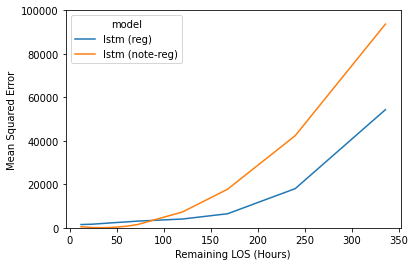

In [63]:
remain_metrics_df = remain_metrics_df.sort_values(by=["model","bin"], ascending=False)
fig = sn.lineplot(data=remain_metrics_df, x="bin", y="mse", hue="model", sort=False)
fig.set(xlabel='Remaining LOS (Hours)')
fig.set(ylabel='Mean Squared Error')
fig.set(ylim=(-12,100000))

In [64]:
model_metrics

{'lstm (note-reg)': {'all': {'mad': 116.45261557342671,
   'mse': 51203.26909965603,
   'mape': 227.26746210159737,
   'kappa': 0.006688145489499142,
   'f1_micro': 0.18105916846984915,
   'f1_macro': 0.04395583355478981,
   'auc': nan,
   'recall': 0.18105916846984915,
   'accuracy': 0.18105916846984915},
  'windsor': {'mad': 48.94876358802066,
   'mse': 6004.899251913242,
   'mape': 255.54960110039224,
   'kappa': 0.004905311874434104,
   'f1_micro': 0.22597038137346287,
   'f1_macro': 0.04956124730605293,
   'auc': nan,
   'recall': 0.22597038137346287,
   'accuracy': 0.22597038137346287},
  'remain': {'mad': 24.51775859282056,
   'mse': 1728.1905031324816,
   'mape': 75.37088714195977,
   'kappa': 0.02841413561129591,
   'f1_micro': 0.1594736605739435,
   'f1_macro': 0.17584870416895867,
   'auc': nan,
   'recall': 0.1594736605739435,
   'accuracy': 0.1594736605739435}},
 'lstm (reg)': {'all': {'mad': 94.93480128154525,
   'mse': 36253.06621090808,
   'mape': 185.09350671825374,
  

In [ ]:
## TESTS
bin = 120
test_df = remain_df[remain_df.remain_bin == bin].copy()
if len(metric_df) == 0:
    continue

print(f"\nMetrics where {bin} hours remaining")
print(f'Unique episodes: {len(test_df.stay.unique())}')
print(f'Unique patients: {len(test_df.PATIENT_ID.unique())}')
print(f'Predictions: {len(test_df)}')
print_metrics_regression(test_df["y_true"], test_df["prediction"], extra=True, custom_bin=2, fill_ones=True)

fig = sn.histplot(data=test_df, x="y_true") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

fig = sn.histplot(data=test_df, x="prediction") #, stat="probability")
fig.set(xlabel='LOS (Hours)')